# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 23th of november at noon**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [21]:
# Change here using YOUR first and last names
fn1 = "marius_bartel"
ln1 = "samo_kamga"
fn2 = "zakaria"
ln2 = "tozy"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_samo_kamga_marius_bartel_and_tozy_zakaria.ipynb


In [90]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [91]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    
$$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [92]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [ ]:
# Util Functions

def grad_linreg(x, A, b):
    """Leas-squares gradient"""
    return -1 * np.dot(A.T,(b-np.dot(A,x)))

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * np.linalg.norm(x, 1) # TODO

def loss_linreg(x, A, b):
    """Least-squares loss"""
    return (np.linalg.norm(b - np.dot(A,x), 2)**2)/ 2 

In [102]:
from IPython.core.display import json
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += (np.dot(A[:,j], residuals)) / lips_const[j]
        # update residuals:
        residuals += np.dot(A[:,j], old_w_j - w[j]) 
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j  = w[j]
        w[j] -= (1/lips_const[j]) * gradient[j]
        # update gradient:
        gradient += np.dot(gram[:, j], (w[j] - old_w_j)) 
        # END TODO
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

In [99]:
from scipy import linalg
w_solve = linalg.solve(np.dot(A.T, A), np.dot(A.T, b))
loss_linreg(w_solve, A, b)

466.3849765337658

In [105]:
# Here we compute a precise minimizer 
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(A.shape[1])
x_min, f_min, _ = fmin_l_bfgs_b(loss_linreg, x_init, grad_linreg,args=(A, b), pgtol=1e-30, factr=1e-30)

print("Precise minimum : ", f_min)
print("Norm of the gradient at the precise minimizer : ", norm(grad_linreg(x_min, A, b)))

Precise minimum :  466.38497653376567
Norm of the gradient at the precise minimizer 3.062725034172051e-06


In [107]:
import time
eps = np.finfo('float').eps

start = time.time()
# Cyclic CD
print("------ Cyclic CD -------")
w_ccd, loss_ccd = cyclic_cd(A, b, n_iter=100*n_features)
print(f"cyclic_cd time performance : {time.time() - start}")
print(f"cyclic_cd mimimum {loss_ccd[-1]}")

# Greedy CD
print("------ Greedy CD -------")
start = time.time()
w_gcd, loss_gcd = greedy_cd(A, b, n_iter=100*n_features)
print(f"greedy_cd time performance : {time.time() - start}")
print(f"greedy_cd mimimum {loss_ccd[-1]}")


------ Cyclic CD -------
cyclic_cd time performance : 0.11498117446899414
cyclic_cd mimimum 466.38497653376584
------ Greedy CD -------
greedy_cd time performance : 0.1229403018951416
greedy_cd mimimum 466.38497653376584


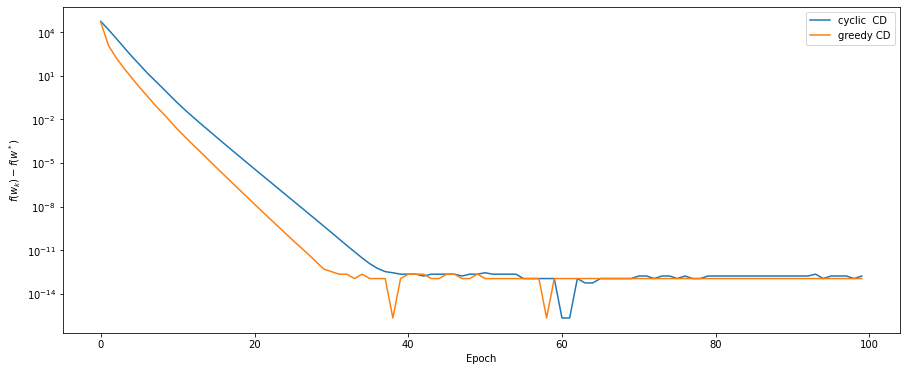

In [108]:
# Visualization
plt.figure(figsize=(15,6))
plt.semilogy(np.maximum(loss_ccd - f_min, eps), label="cyclic  CD")
plt.semilogy(np.maximum(loss_gcd - f_min, eps), label= "greedy CD")
plt.xlabel("Epoch")
plt.ylabel("$f(w_k) - f(w^*)$")
plt.legend()
plt.show()

<div class="alert alert-success">
   
$\bullet$ <strong>Compare performance of Cyclic and greedy CD: </strong> 

Our objective function in convex and smooth so aspected the method converge also we see that greedy cd is better.

$\bullet$ <strong>Greedy CD for OLS with 100000 features :</strong> 

From a pratical point of view Greedy CD is not a good choice because of the presence of the n^3 that we have in the upper bound of the difference between the objective function at the iterate minus the mimimum and obviously at each iteration looking over the entire gradient to find the coordinate with the largest magnitude will be really costly.
</div>

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
  Assuming uniqueness of the solution, show that: $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.
</div>

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

***answer here***

<div class="alert alert-info">
    <h2><strong>Answer :  </strong></h2>

First, let $L(w) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )$ we have the following gradient :  $\nabla L(w) = -\sum_{i=1}^n \frac{y_i x_i}{1+e^{y_i x_i^\top w}}$

Moreover,
$$
\begin{split}
\partial (L(w) + \lambda \Vert \cdot \Vert_1 (w)) & = \nabla L(w) + \lambda \partial \Vert \cdot \Vert_1 (w) \\ & = - \sum_{i=1}^n \frac{y_i x_i}{1+e^{y_i x_i^\top w}} + \lambda \partial \Vert \cdot \Vert_1 (w)
\end{split}
$$

And at $w = \mathbf{0}_p$:

$$
\partial (L(\mathbf{0}_p) + \lambda \Vert \cdot \Vert_1 (\mathbf{0}_p)) = - \frac{1}{2} \sum_{i=1}^n y_i x_i + [-\lambda,\lambda]^p
$$

Using the Fermat's rule:

$$
\begin{split}
\mathbf{0}_p \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1
&\iff 0 \in \partial (L(\mathbf{0}_p) + \lambda \Vert \cdot \Vert_1 (\mathbf{0}_p))\\
&\iff \frac{1}{2} \sum_{i=1}^n y_i x_i \in [-\lambda,\lambda]^p\\
&\iff \frac 12 \Vert X^\top y \Vert_{\infty} \leq \lambda \\
&\iff \lambda_\max \leq \lambda
\end{split}
$$


We've just proofed the equivalence, which results in:
$$ \lambda \geq \lambda_{max} \implies \hat w = 0$$

</div>

<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
  Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

***answer here***
<div class="alert alert-info">  
    <b>Answer</b>:  

First, let f be :  

$$f(w)=\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )$$  

The derivative of $f$ w.r.t $w_j$ :  

$$\frac {\partial f(w)}{\partial w_j}=\sum_{i=1}^{n} \frac{-y_i x_{ij}}{1+e^{y_i w^\top x_i}}$$  

The second derivative of $f$ w.r.t $w_j$ :  

$$\frac {\partial^2 f(w)}{\partial w_j^2}=\sum_{i=1}^{n} \frac{y_i^2 x_{ij}^2 e^{y_i w^\top x_i}}{(1+e^{y_i w^\top x_i})^2}$$  

However, we know that :  

$$   \frac {e^{\alpha}}{(1+  e^{\alpha})^2} \leq \frac 14 \quad \forall \alpha$$ 

$$  y_i^2 = 1 \quad \forall i$$  

Conclusion : $$\frac {\partial^2 f(w)}{\partial w_j^2} \leq \frac 14 \sum_{i=1}^{n} x_{ij}^2 = \frac 14 \Vert X_j \Vert ^2 = L_j $$

<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [134]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs



def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    all_objs = np.zeros(n_iter+1)
    w = np.zeros(n_features)
    Xw = X.dot(w)
    all_objs[0] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    # TODO
    lips_const = np.linalg.norm(X, axis=0) ** 2 / 4. 
    # END TODO
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = -np.sum(y * X[:,j] * sigmoid(-(y * Xw)))
            w[j] =  soft_thresh(old_w_j  - (grad_j / lips_const[j]) , lamb / lips_const[j])
            
            if old_w_j != w[j]:
              Xw += X[:,j] * ( w[j] - old_w_j)
            #END TODO
            
        all_objs[t+1] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

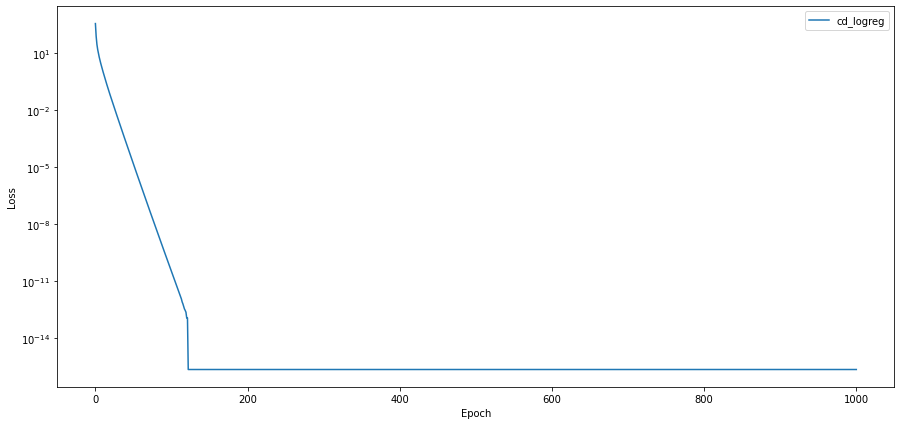

In [136]:
w_cd_log, loss_cd_log = cd_logreg(X=X, y=y, lamb=lamb, n_iter= 1000 )
plt.figure(figsize=(15,7))
plt.semilogy(np.maximum(loss_cd_log - loss_cd_log[-1], eps),label="cd_logreg")
plt.legend()
plt.xlabel("Epoch") 
plt.ylabel("Loss")
plt.show()

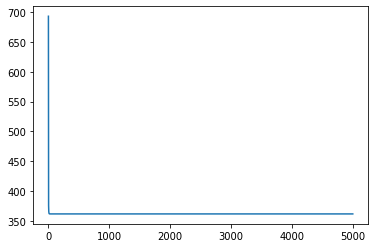

In [95]:
w_cd_log, loss_cd_log = cd_logreg(X=X, y=y, lamb=lamb, n_iter= X.shape[1] * 50 )
plt.plot(b)

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [140]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [141]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).

In [142]:
def grad_linreg(x, A=X, b=y):
    """Leas-squares gradient"""
    return -1 * np.dot(A.T,(b-np.dot(A,x)))

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * np.linalg.norm(x, 1) # TODO

def loss_linreg(x, A=X, b=y):
    """Least-squares loss"""
    return (np.linalg.norm(b - np.dot(A,x), 2)**2)/ 2 
  
def PGD(A, f, grad_f, R, prox_R, lmbd=0., n_iter=200):
    """Proximal gradient descent algorithm"""
    n_samples, n_features = A.shape
    x0 = np.zeros(n_features)
    x = x0.copy()
    x_new = x0.copy()
    step = np.linalg.norm(A, ord=2) ** 2
    
    # objective history
    objectives = []
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    for k in range(n_iter):
        x = prox_R(x - (grad_f(x) / step), lmbd / step)     
        obj = f(x) + R(x, lmbd)
        if (k+1) % n_features == 0 :
          objectives.append(obj)
    return x, objectives

In [143]:
def cd_lingreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    all_objs = np.zeros(n_iter+1)
    w = np.zeros(n_features)
    gradient = X.T.dot(X.dot(w) - y)
    gram = X.T.dot(X)
    all_objs[0] =  0.5 * np.linalg.norm(X.dot(w) - y) ** 2
    
    # TODO
    lips_const = np.linalg.norm(X, axis=0) ** 2 
    # END TODO
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = gradient[j]
            w[j] =  soft_thresh(old_w_j  - (grad_j / lips_const[j]) , lamb / lips_const[j])          
            if old_w_j != w[j]:
              gradient += np.dot(gram[:, j], (w[j] - old_w_j))
            #END TODO       
        all_objs[t+1] = 0.5 * np.linalg.norm(X.dot(w) - y) ** 2
    
    return w, all_objs

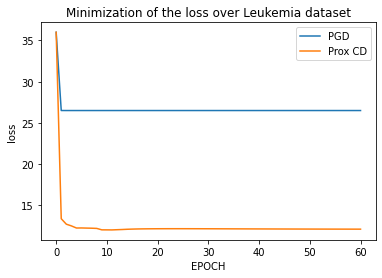

In [145]:
w_pgd,loss_pgd = PGD(A=X, f=loss_linreg, grad_f=grad_linreg, R=L1_norm, prox_R=soft_thresh, 
                     lmbd=lambd, n_iter=X.shape[1]*60)

w_cd_lin,loss_cd_lin = cd_lingreg(X=X, y=y, lamb=lambd, n_iter=60)

plt.figure()
plt.plot(loss_pgd, label = "PGD")
plt.plot(loss_cd_lin, label = "Prox CD")
plt.title("Minimization of the loss over Leukemia dataset")
plt.xlabel("EPOCH")
plt.ylabel("loss")
plt.legend()
plt.show()